In [85]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

## Target

In [177]:
LOCAL_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/energy_generation_data/df_deutschland.csv'

def get_target_data(path=LOCAL_PATH, target='wind', hourly=True):
    if hourly:
        path = path.replace('daily/','hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()    
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

target_df = get_target_data(target='wind', hourly=True)


In [178]:
target_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

target_scaled = target_pipe.fit_transform(pd.DataFrame(target_df.to_numpy(), index=target_df.index))
target_scaled_df = pd.Series(target_scaled.squeeze(), index=target_df.index)

## Features

In [179]:
def get_best_station_ids(features_df, target_df, corr=0.6):
    features_df['target'] = target_df
    corr_df = features_df.corr()
    best_stations = list(corr_df['target'][corr_df['target']>=corr].index)[:-1]
    init_length = len(features_df.columns)
    final_length = len(best_stations)
    print(f'Droped {init_length - final_length} stations!')
    
    return best_stations

In [180]:
FEATURES_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/features'

hourly_files = {'wind_speed': 'wind_hourly_clean.csv',
                 'air_pressure': 'hourly_airp_df.csv',
                 'humidity': 'hourly_humidity_df.csv',
                 'temperature': 'hourly_temperature_df.csv',
                 'clouds': 'hourly_cloud_df.csv'}

daily_files = {'wind_speed': 'winddailyofeverystation.csv',
               'air_pressure': 'daily_airp_df.csv',
               'humidity': None,
               'temperature': None,
               'clouds': None}


def get_features_data(path=FEATURES_PATH, features=['wind_speed'], optimized=True, grouped=True, hourly=False):
    df = pd.DataFrame(index=target_df.index)
    
    for feature in features:
        if hourly and hourly_files[feature]:
            path = FEATURES_PATH.replace('/daily/features',f'/hourly/features/{hourly_files[feature]}')
        elif daily_files[feature]:
            path = f'{path}/winddailyofeverystation.csv'
        else:
            continue
        feat_df = pd.read_csv(path, index_col='Date')
        feat_df.index = pd.to_datetime(feat_df.index)
        if optimized:
            best_stations = get_best_station_ids(feat_df, target_df)
            feat_df = feat_df[best_stations]
        if grouped:
            feat_df = feat_df.mean(axis=1)
            df[feature] = feat_df
        else:
            feat_df.rename(columns = {column: f'{column}_{feature[0]}' for column in feat_df.columns}, inplace=True)
            df = df.join(feat_df)

    return df

features_df = get_features_data(features =['wind_speed', 'air_pressure', 'humidity', 'temperature'], optimized=False, grouped=True, hourly=True)


In [181]:
feature_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

feat_scaled = feature_pipe.fit_transform(features_df)
feat_scaled_df = pd.DataFrame(feat_scaled, columns=features_df.columns, index=features_df.index)

##  Forecasted

In [8]:
FORCASTED_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/forecasted_generation_data/df_deutschland_forecasted.csv'

def get_forcasted_data(path=FORCASTED_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('/daily/', '/hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

forcasted_df = get_forcasted_data(target='wind', hourly=True)
    

# Statistical exploration

## Train Test Split

In [13]:
def get_X_y(target_df, features_df, init_date=dt.datetime(2015,1,1), end_date=dt.datetime(2016,1,1), scaled=False):
    '''return the the target and features data between the init_date and end_date time window'''
    if scaled:
        target_df = pd.Series(np.log(target_df.values), index=target_df.index)
    X = features_df.loc[init_date:end_date,:]
    y = target_df.loc[init_date:end_date]
    return X, y

X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,6,1), end_date=dt.date(2021,1,5), scaled=True)

<ipython-input-13-525d6fe1ef14>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [285]:
def train_test_split(X, y, train_end='2021-1-1', test_init='2021-1-1', test_end='2021-1-4'):
    X_train = X.loc[:train_end]
    X_test = X.loc[test_init:test_end]
    y_train = y.loc[:train_end]
    y_test = y.loc[test_init:test_end]
    
    return X_train, X_test, y_train, y_test

days = 4
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Stationarity

### Visually

<AxesSubplot:>

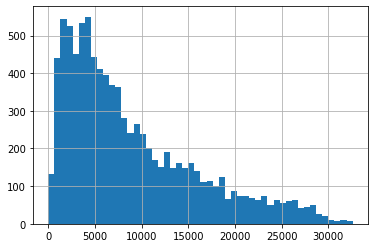

In [9]:
y.hist(bins=50)

<AxesSubplot:xlabel='Date'>

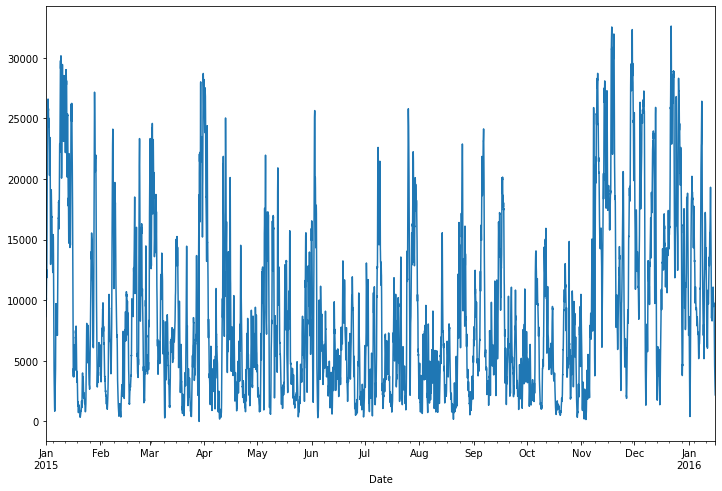

In [10]:
plt.subplots(figsize=(12,8))
y.plot()

###  Calculations (mean, variance and autocorrelation)

In [143]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m).dropna()
    if d > 0:
        for i in range(d):
            y = y.diff(1).dropna()
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

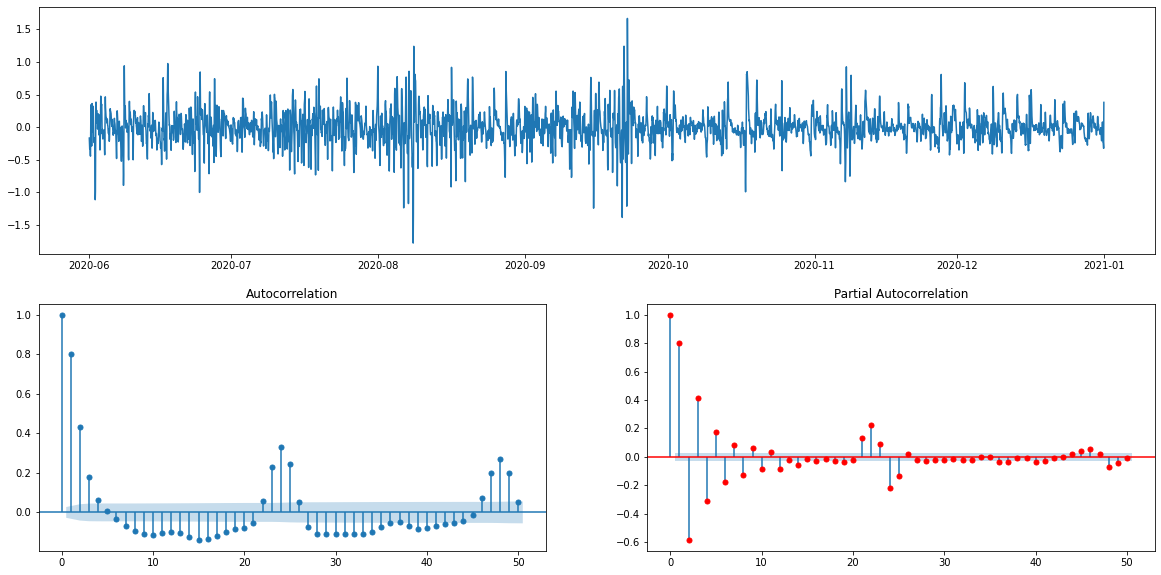

In [144]:
plot_autocorrelation(y_train, d=0, D=1, m=2)

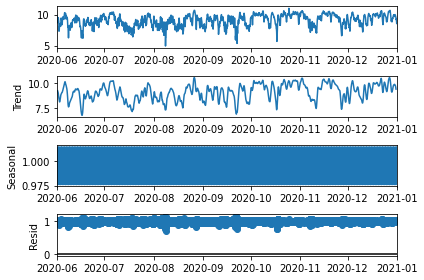

In [145]:
result_add = seasonal_decompose(y_train, model='multiplicative')
result_add.plot();

<AxesSubplot:xlabel='Date'>

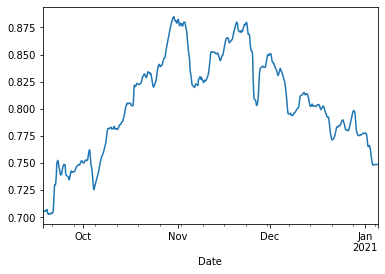

In [146]:
y.rolling(window=int(len(y)/2)).var().dropna().plot()

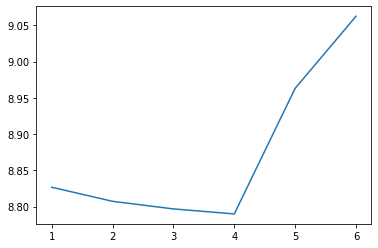

In [147]:
means = []

for year in range(1, 8):
    means.append(y[f'2020-{year}':f'2020-{year+4}'].mean())

plt.plot(means)

In [154]:
# p-value (should be less than 0.05 to be sattionary)
adfuller(y_train)[1]

4.7329962368288775e-11

0.008671698273998753

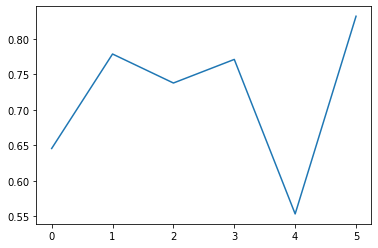

In [156]:
var = []

for month in range(6, 12):
    var.append(y[f'2020-{month}'].var())

plt.plot(var)
np.array(var).var()

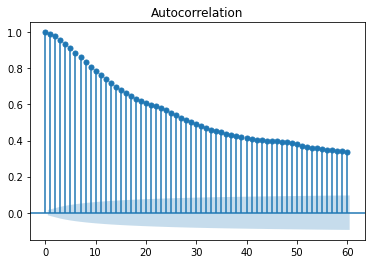

In [301]:
plot_acf(y.dropna(), lags=60);

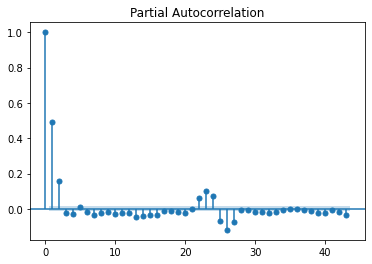

In [302]:
plot_pacf(y.diff().dropna());

In [157]:
adfuller(y.diff(24).dropna())

(-13.015266629267176,
 2.5187179923880642e-24,
 32,
 5176,
 {'1%': -3.4316140158442305,
  '5%': -2.8620985625001385,
  '10%': -2.56706732277764},
 -10244.134358646596)

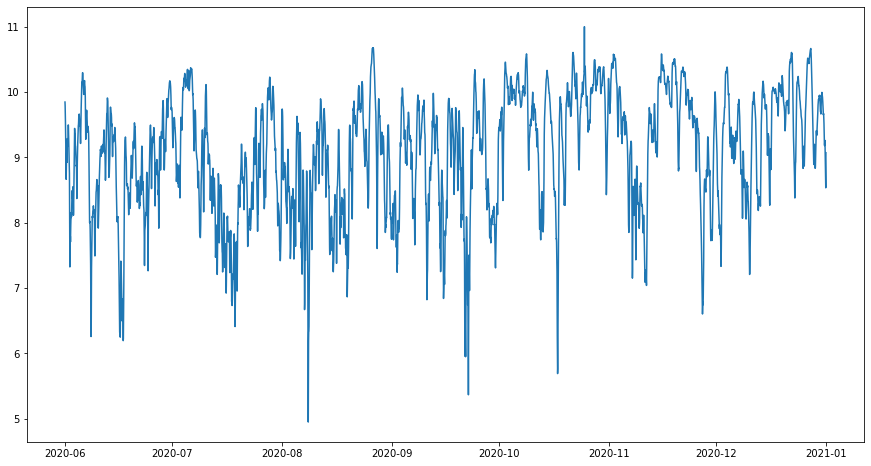

In [158]:
plt.subplots(figsize=(15,8))
plt.plot(y_train)

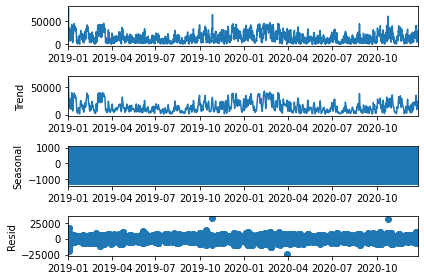

In [189]:
result_mul = seasonal_decompose(y_train, model='addictive')
result_mul.plot();

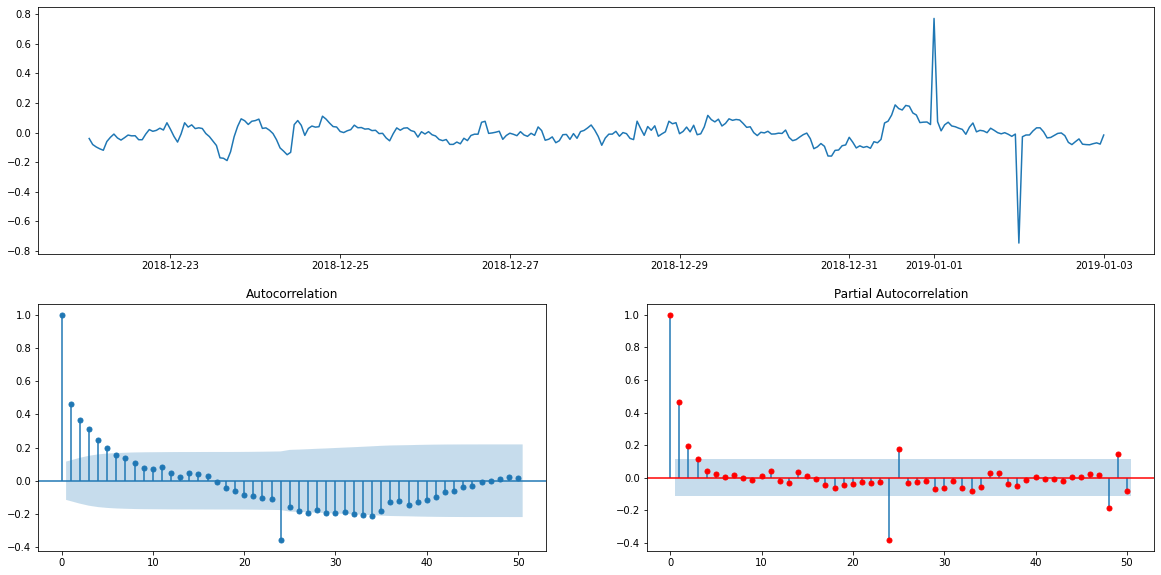

In [68]:
plot_autocorrelation(y['2018-12-22':], d=1, D=0, m=24)

# Models

## Auto-ARIMA 0

In [305]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=24, X=X_train.to_numpy(),
                       start_p=0, max_p=2,
                       start_d=0, max_d=1,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_D=0, max_D=3,
                       start_Q=0, max_Q=2,
                       seasonal=True, trace=True, njobs=-1, error_action='ignore',  
                       stepwise=False, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=7027.811, Time=0.91 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-7239.472, Time=38.35 sec


/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=6811.202, Time=10.76 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=7073.849, Time=3.69 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-6601.474, Time=3.18 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-7369.619, Time=105.68 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-7338.536, Time=149.09 sec


KeyboardInterrupt: 

In [ ]:
smodel.summary()

In [ ]:
central, confint = smodel.predict(n_periods=len(y_test), X=X_test, return_conf_int=True)
index_y_test = y_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

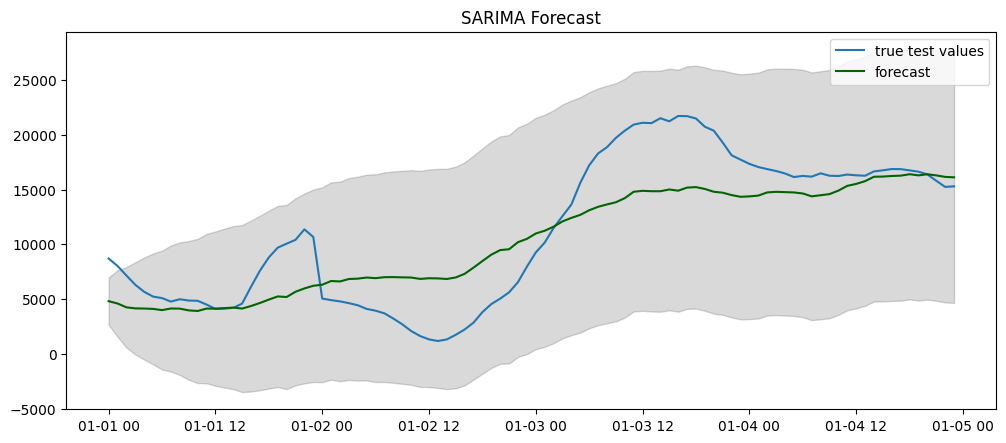

In [300]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [301]:
mean_absolute_percentage_error(y_test, central)

53.75506367656674

## Auto-ARIMA 1

In [302]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,7,1), end_date=dt.date(2021,1,31), scaled=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2020-12-31', test_init='2021-1-1', test_end='2021-1-4',)

<ipython-input-13-525d6fe1ef14>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [291]:
import pmdarima as pm

smodel_1 = pm.auto_arima(y_train, m=12, X=X_train.to_numpy(),
                       start_p=0, max_p=2,
                       start_d=0, max_d=1,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_D=0, max_D=1,
                       start_Q=0, max_Q=2,
                       seasonal=True, trace=True, njobs=-1, error_action='ignore',  
                       stepwise=False, suppress_warnings=True)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=86704.174, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=86365.301, Time=9.48 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=85610.895, Time=12.67 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=86055.888, Time=2.60 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=85727.086, Time=10.74 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=30.61 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=26.44 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=25.98 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=26.34 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=81930.101, Time=2.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=81659.434, Time=11.30 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=81537.779, Time=27.40 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=81358.764, Time=9.33 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=81730.218, Time=13.44 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=31.13 sec


In [293]:
smodel_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 4416
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood              -37157.250
Date:                             Thu, 17 Jun 2021   AIC                          74336.500
Time:                                     00:22:25   BIC                          74406.823
Sample:                                          0   HQIC                         74361.303
                                            - 4416                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7821   1172.863     -0.002      0.999   -2300.552    2296.988
x1          7240.8715    146.956     49.272      0.000    6952.843    7528.900
x2           -37.3738     53.287     -0.701      0.483    -141.815      67.067
x3           319.0550     28.841     11.062      0.000     262.527     375.583
x4            67.7145     94.156      0.719      0.472    -116.828     252.257
ar.L1          1.5823      0.037     42.962      0.000       1.510       1.655
ar.L2         -0.6112      0.036    -16.800      0.000      -0.682      -0.540
ma.L1         -0.4230      0.036    -11.662      0.000      -0.494      -0.352
ar.S.L12      -0.0020      0.019     -0.103      0.918      -0.039       0.035
ar.S.L24       0.2299      0.003     70.822      0.000       0.224       0.236
sigma2      1.224e+06   5042.864    242.801      0.000    1.21e+06    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):          25635025.40
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                       376.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [294]:
central, confint = smodel_1.predict(n_periods=len(y_test), X=X_test, return_conf_int=True)
index_y_test = y_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

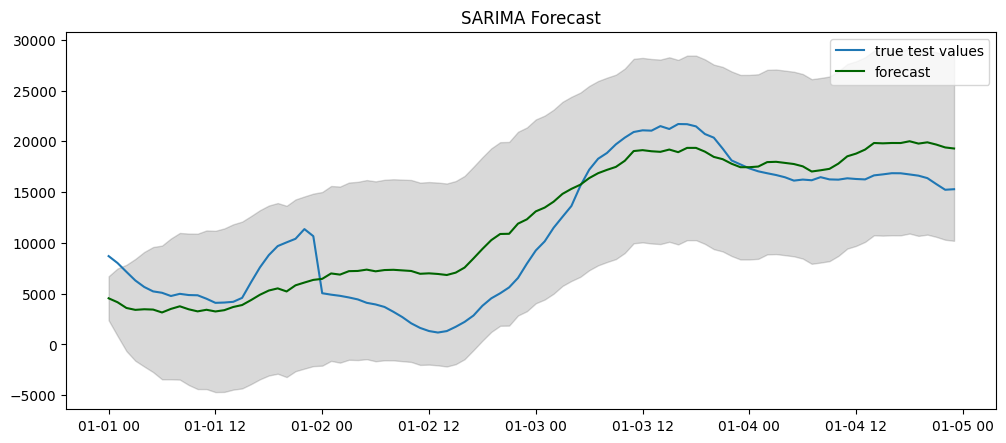

In [295]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [296]:
mean_absolute_percentage_error(y_test, central)

57.45237617421366

## SARIMAX 0

In [169]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [170]:
sarimax = SARIMAX(endog=y_train, exog=X_train, order=(2,1,0), seasonal_order=(2,0,0,24)).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
y_pred = sarimax.predict(len(X_test), exog=X_test, alpha=0.05)

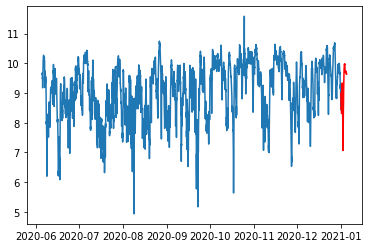

In [185]:
plt.plot(y_pred)
plt.plot(y_test, color='r')
#plt.plot(central, color='g')

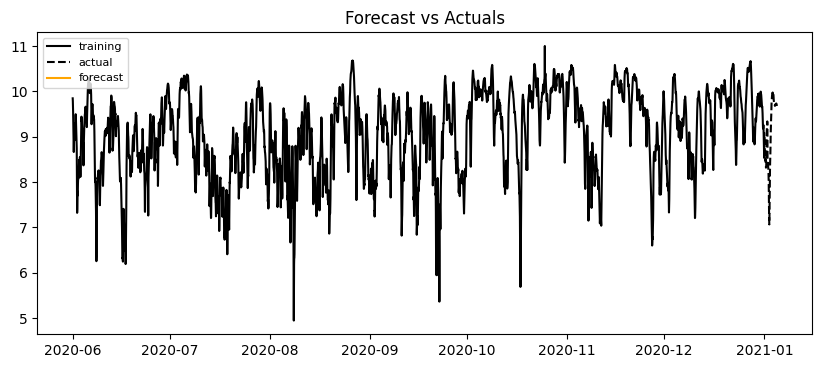

In [186]:
plot_forecast(y_pred, y_train, y_test)

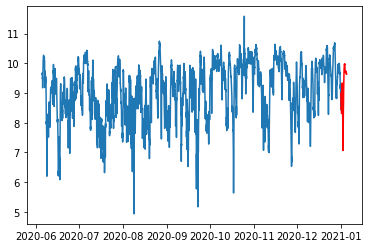

In [189]:
plt.plot(y_pred)
plt.plot(y_test, color='r')

In [180]:
y_pred.shape

(5041,)

In [179]:
mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))

ValueError: operands could not be broadcast together with shapes (96,) (5041,) 

## SARIMAX 1

 **Model_1**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = log(target)
 - model: **SARIMAX (2,0,2)(2,0,2)[24]**

In [21]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,6,1), end_date=dt.date(2021,1,5), scaled=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*days)

# train model
sarimax_1 = SARIMAX(y_train, 
                    exog=X_train, order=(2,0,2), 
                    seasonal_order=(2,0,2,24), 
                    time_varying_regression=False).fit()

#get predicitons and confidence interval
sarimax_result = sarimax_1.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

<ipython-input-13-525d6fe1ef14>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [95]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

7.195811338454076

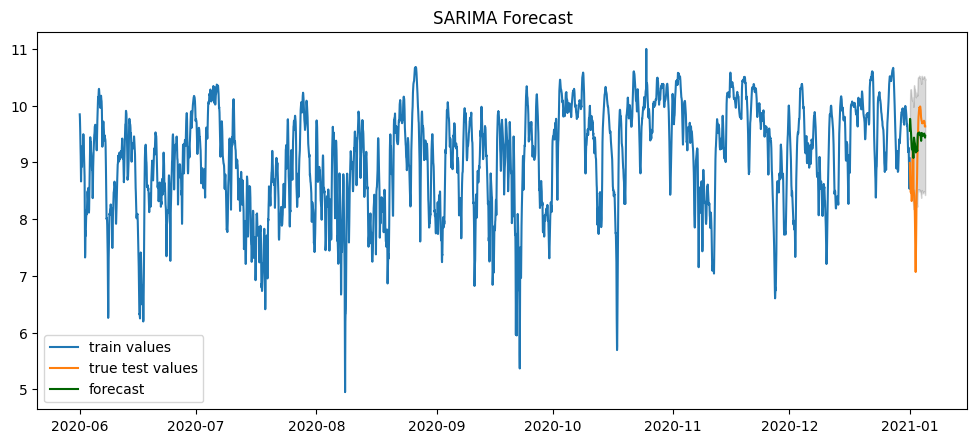

In [65]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

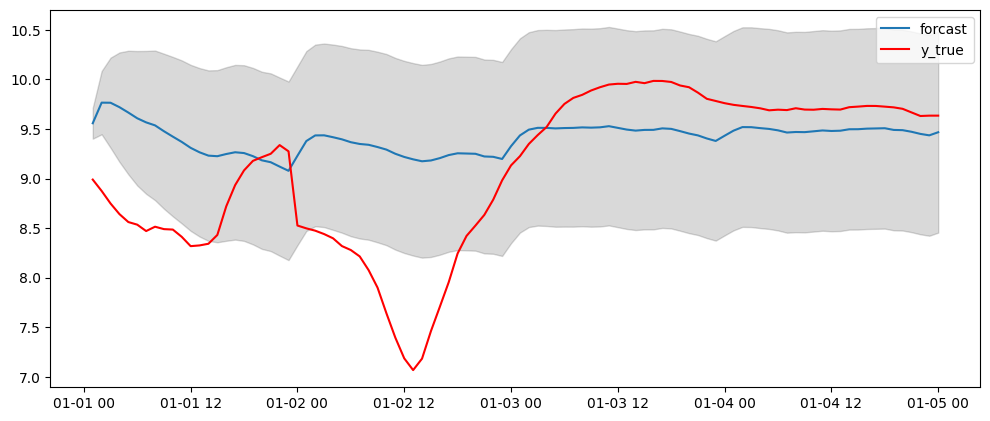

In [78]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 2

 **Model_2**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (2,1,0)(2,0,1)[24]**

In [105]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*15)

# train model
sarimax_2 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,0), 
                    seasonal_order=(2,0,1,24), 
                    time_varying_regression=False).fit()

In [111]:
sarimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 2185
Model:             SARIMAX(2, 1, 0)x(2, 0, [1], 24)   Log Likelihood              -18654.276
Date:                              Wed, 16 Jun 2021   AIC                          37330.552
Time:                                      21:19:59   BIC                          37393.130
Sample:                                  10-01-2020   HQIC                         37353.427
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    5634.2739    260.024     21.668      0.000    5124.636    6143.911
air_pressure  -280.9006     88.113     -3.188      0.001    -453.599    -108.203
clouds        -459.8361    184.187     -2.497      0.013    -820.835     -98.837
humidity       291.7880     56.108      5.200      0.000     181.819     401.757
temperature   -514.3509    212.854     -2.416      0.016    -931.537     -97.165
ar.L1           -0.0014      0.005     -0.253      0.800      -0.012       0.009
ar.L2            0.0120      0.006      2.092      0.036       0.001       0.023
ar.S.L24         0.9507      0.044     21.654      0.000       0.865       1.037
ar.S.L48         0.0058      0.006      0.944      0.345      -0.006       0.018
ma.S.L24        -0.9504      0.044    -21.732      0.000      -1.036      -0.865
sigma2        1.516e+06   1.05e+04    144.173      0.000     1.5e+06    1.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9269805.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                       322.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
#get predicitons and confidence interval
sarimax_result = sarimax_1.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [107]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

81.5546368265491

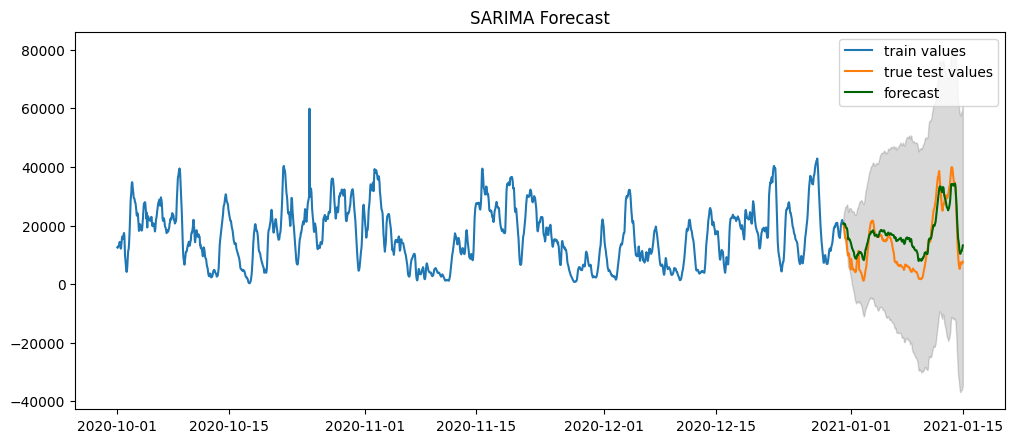

In [108]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

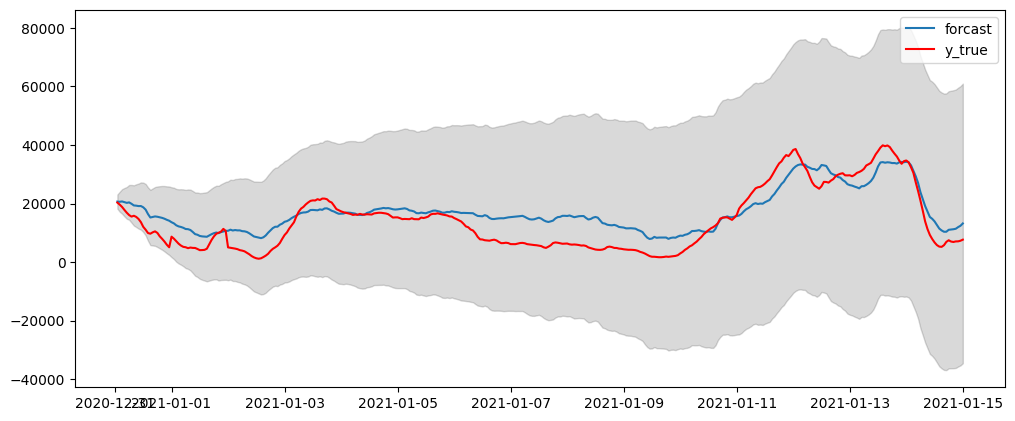

In [109]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 3

 **Model_3**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (2,1,2)(2,0,2)[12]**

In [128]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*15)

# train model
sarimax_3 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,2), 
                    seasonal_order=(2,0,2,12), 
                    time_varying_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [129]:
sarimax_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2185
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -18652.697
Date:                            Wed, 16 Jun 2021   AIC                          37333.394
Time:                                    21:39:09   BIC                          37413.039
Sample:                                10-01-2020   HQIC                         37362.508
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    5634.2739    259.779     21.689      0.000    5125.117    6143.431
air_pressure  -280.9106     91.436     -3.072      0.002    -460.122    -101.699
clouds        -459.8380    183.219     -2.510      0.012    -818.941    -100.735
humidity       291.7657     56.768      5.140      0.000     180.502     403.029
temperature   -514.3439    213.928     -2.404      0.016    -933.635     -95.053
ar.L1            0.6831      0.465      1.469      0.142      -0.228       1.594
ar.L2           -0.0641      0.588     -0.109      0.913      -1.216       1.087
ma.L1           -0.6847      0.465     -1.474      0.141      -1.595       0.226
ma.L2            0.0774      0.587      0.132      0.895      -1.073       1.228
ar.S.L12         0.0938      0.841      0.112      0.911      -1.554       1.741
ar.S.L24         0.8673      0.820      1.057      0.290      -0.740       2.475
ma.S.L12        -0.0905      0.843     -0.107      0.915      -1.743       1.562
ma.S.L24        -0.8622      0.819     -1.052      0.293      -2.468       0.744
sigma2        1.508e+06   9490.679    158.910      0.000    1.49e+06    1.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9284189.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       322.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
#get predicitons and confidence interval
sarimax_result = sarimax_3.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [131]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

83.20463376901776

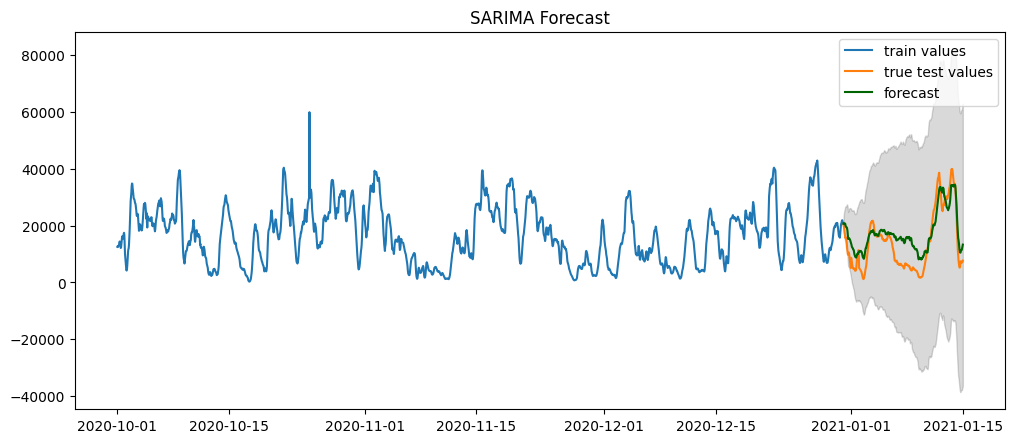

In [132]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

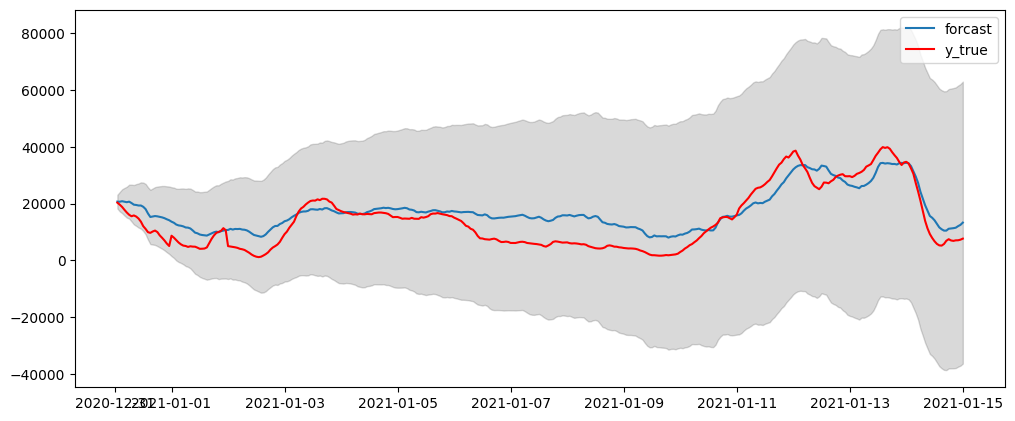

In [133]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 4

 **Model_4**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,1)(1,0,1)[24]**

In [134]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*15)

# train model
sarimax_4 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,1,24), 
                    time_varying_regression=False).fit()

In [135]:
sarimax_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2185
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -18655.117
Date:                            Wed, 16 Jun 2021   AIC                          37330.234
Time:                                    21:43:38   BIC                          37387.124
Sample:                                10-01-2020   HQIC                         37351.030
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    5634.4581    257.152     21.911      0.000    5130.450    6138.467
air_pressure  -278.5249     70.401     -3.956      0.000    -416.508    -140.541
clouds        -459.7631    184.694     -2.489      0.013    -821.756     -97.770
humidity       289.7023     52.535      5.514      0.000     186.736     392.669
temperature   -513.7949    197.410     -2.603      0.009    -900.712    -126.878
ar.L1            0.9968      0.006    160.387      0.000       0.985       1.009
ma.L1           -0.9975      0.005   -184.911      0.000      -1.008      -0.987
ar.S.L24         0.9603      0.037     26.017      0.000       0.888       1.033
ma.S.L24        -0.9541      0.039    -24.515      0.000      -1.030      -0.878
sigma2        1.535e+06   4892.091    313.772      0.000    1.53e+06    1.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9253490.75
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                       321.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
#get predicitons and confidence interval
sarimax_result = sarimax_4.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [137]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

81.93858933728849

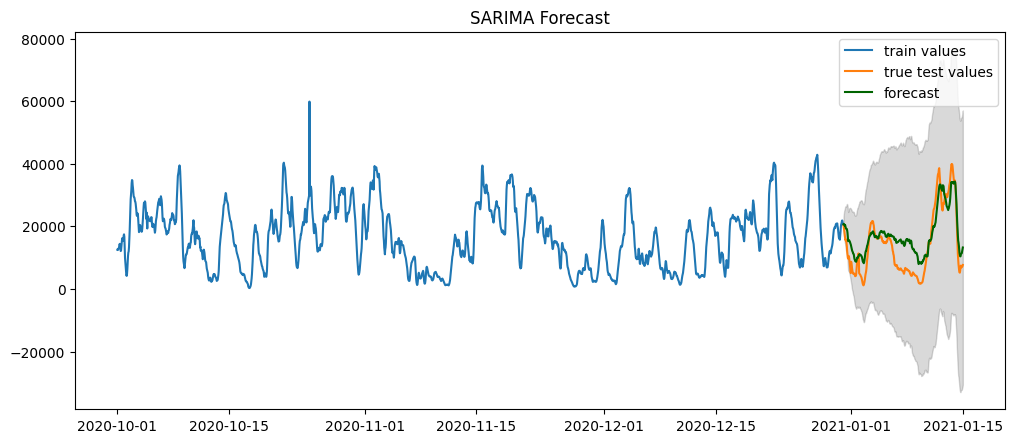

In [138]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

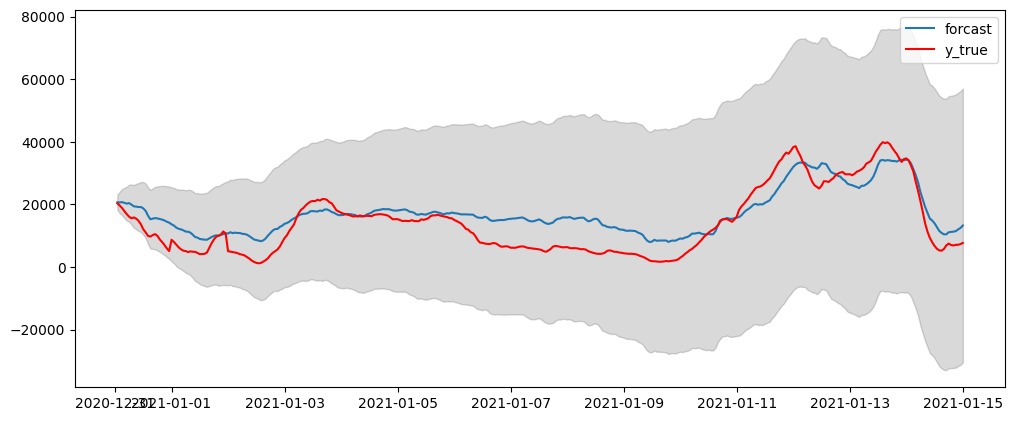

In [139]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 5

 **Model_5**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = target and feature
 - model: **SARIMAX (1,1,1)(1,0,2)[24]**

In [140]:
# split data
X, y = get_X_y(target_scaled_df, feat_scaled_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*15)

# train model
sarimax_5 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=False).fit()

In [141]:
sarimax_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2185
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood                5947.055
Date:                                 Wed, 16 Jun 2021   AIC                         -11872.110
Time:                                         21:47:21   BIC                         -11809.532
Sample:                                     10-01-2020   HQIC                        -11849.235
                                          - 12-31-2020                                         
Covariance Type:                                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed       0.7822      0.048     16.445      0.000       0.689       0.875
air_pressure    -0.4145      0.113     -3.662      0.000      -0.636      -0.193
clouds          -0.0294      0.021     -1.390      0.164      -0.071       0.012
humidity         0.1569      0.063      2.483      0.013       0.033       0.281
temperature     -0.5430      0.153     -3.548      0.000      -0.843      -0.243
ar.L1            0.7807      0.130      5.989      0.000       0.525       1.036
ma.L1           -0.7206      0.133     -5.427      0.000      -0.981      -0.460
ar.S.L24         0.6748      0.119      5.684      0.000       0.442       0.907
ma.S.L24        -0.5940      0.118     -5.027      0.000      -0.826      -0.362
ma.S.L48         0.0361      0.021      1.684      0.092      -0.006       0.078
sigma2           0.0003   1.81e-06    139.624      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  18.14   Jarque-Bera (JB):          13368445.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                       386.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
#get predicitons and confidence interval
sarimax_result = sarimax_5.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [144]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

99.87604601355

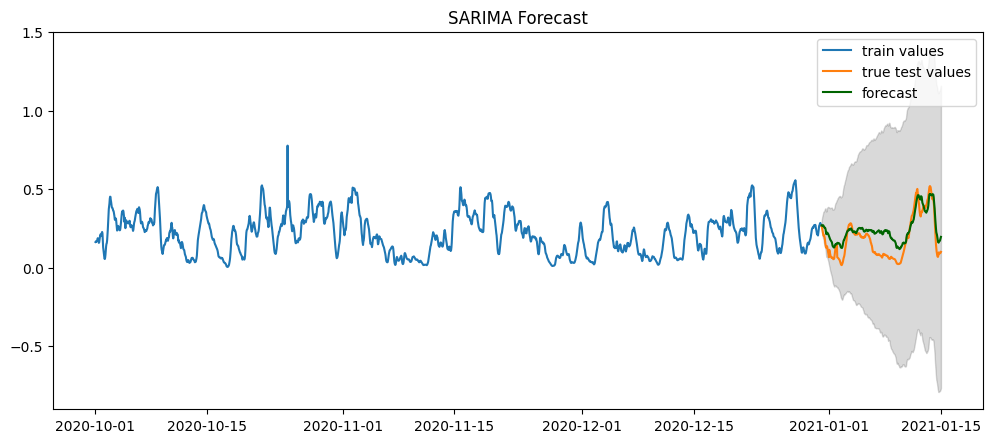

In [145]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

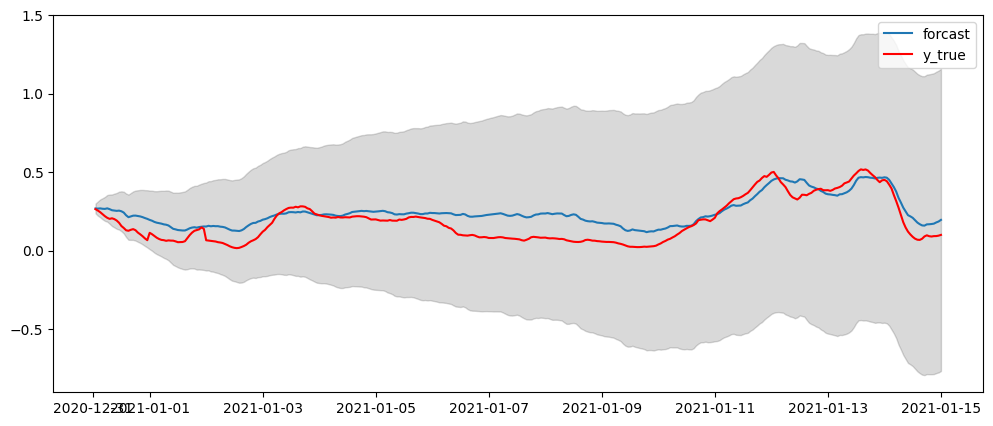

In [146]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 6

 **Model_6**:
 - Train size = 1 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,1)(1,0,1)[24]**

In [156]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,12,1), end_date=dt.date(2021,1,5))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*4)

# train model
sarimax_6 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,1,24), 
                    time_varying_regression=False).fit()

In [158]:
sarimax_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  745
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -5808.357
Date:                            Wed, 16 Jun 2021   AIC                          11636.715
Time:                                    22:40:59   BIC                          11682.835
Sample:                                12-01-2020   HQIC                         11654.493
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    7041.2283    301.002     23.393      0.000    6451.276    7631.181
air_pressure   -49.1872     10.775     -4.565      0.000     -70.306     -28.069
clouds        -169.2579    145.131     -1.166      0.244    -453.709     115.193
humidity       545.3944     75.958      7.180      0.000     396.519     694.270
temperature   -639.3311    266.526     -2.399      0.016   -1161.713    -116.950
ar.L1            0.5919      0.052     11.371      0.000       0.490       0.694
ma.L1           -0.0733      0.067     -1.095      0.274      -0.205       0.058
ar.S.L24         0.9700      0.027     36.194      0.000       0.918       1.023
ma.S.L24        -0.9182      0.046    -19.959      0.000      -1.008      -0.828
sigma2        3.659e+05   1.33e+04     27.474      0.000     3.4e+05    3.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               681.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
#get predicitons and confidence interval
sarimax_result = sarimax_6.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [160]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

102.23257262118916

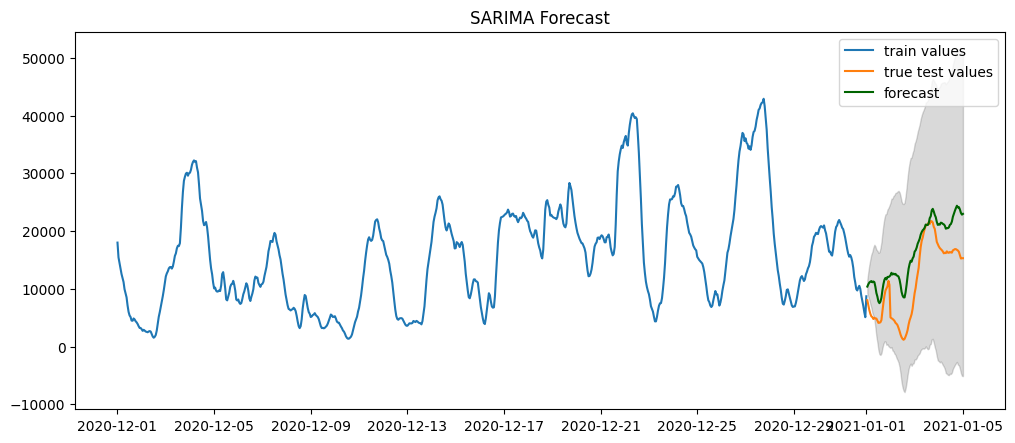

In [161]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

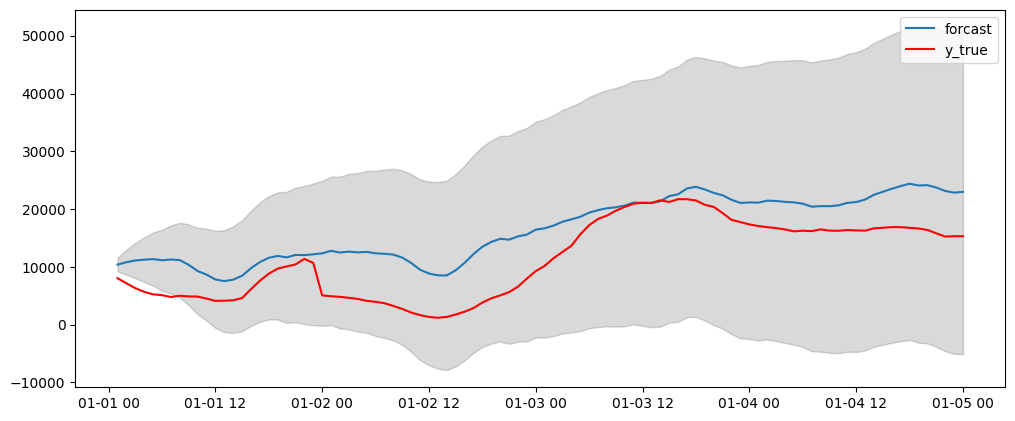

In [162]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 7

 **Model_7**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,2)(1,0,1)[24]**
 - time_varying_regression=True

In [255]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,7,1), end_date=dt.datetime(2021,1,5))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*4)

In [189]:
# train model
sarimax_7 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=True, 
                    mle_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
sarimax_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 4417
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -36793.186
Date:                                 Wed, 16 Jun 2021   AIC                          73606.371
Time:                                         23:00:04   BIC                          73670.292
Sample:                                     07-01-2020   HQIC                         73628.917
                                          - 01-01-2021                                         
Covariance Type:                                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1                0.3293      0.081      4.078      0.000       0.171       0.488
ma.L1                0.1477      0.005     29.759      0.000       0.138       0.157
ar.S.L24             0.7449      0.040     18.736      0.000       0.667       0.823
ma.S.L24             0.0921      0.016      5.898      0.000       0.062       0.123
ma.S.L48             0.0251      0.024      1.038      0.299      -0.022       0.072
var.wind_speed    2.388e+04   3440.244      6.941      0.000    1.71e+04    3.06e+04
var.air_pressure     0.0012      0.063      0.019      0.985      -0.123       0.125
var.humidity         0.0003      1.210      0.000      1.000      -2.372       2.373
var.temperature     73.4435     50.859      1.444      0.149     -26.238     173.125
sigma2            9.777e+05      2.984   3.28e+05      0.000    9.78e+05    9.78e+05
===================================================================================
Ljung-Box (L1) (Q):                  19.89   Jarque-Bera (JB):          32558735.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -2.16
Prob(H) (two-sided):                  0.01   Kurtosis:                       423.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.16e+22. Standard errors may be unstable.
"""

In [256]:
#get predicitons and confidence interval
sarimax_result = sarimax_7.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [257]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

46.66707359268132

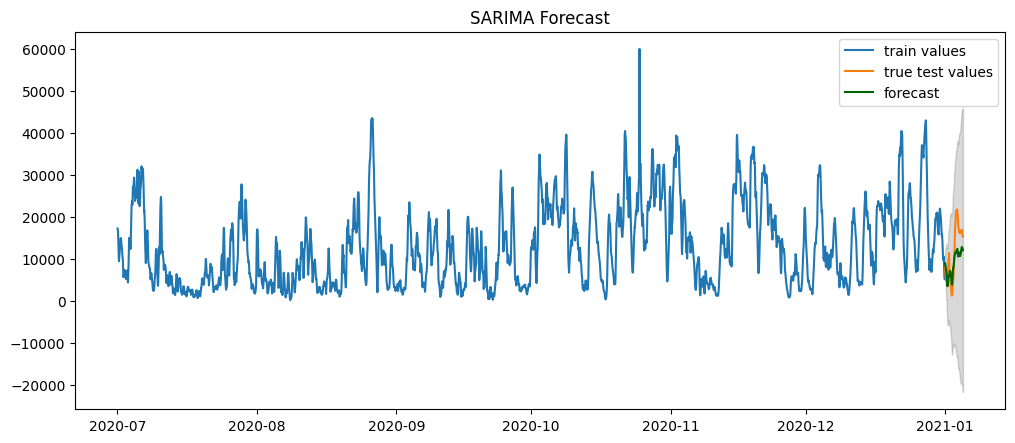

In [258]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

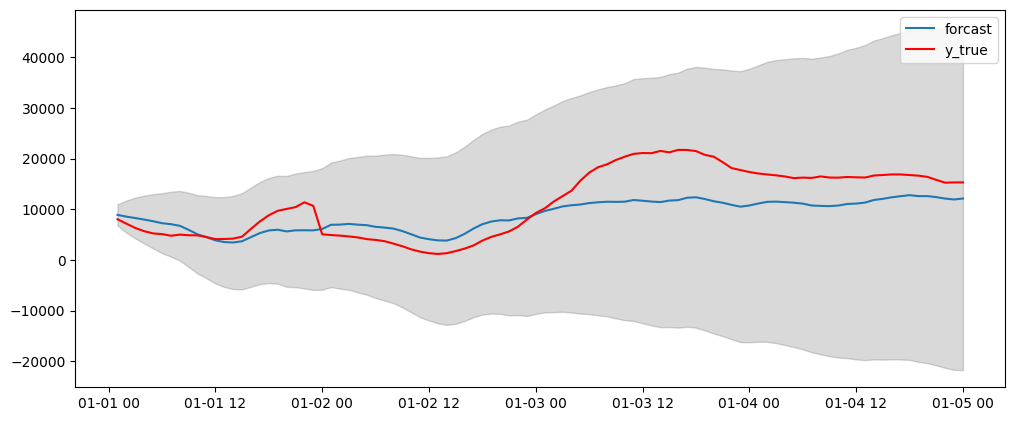

In [259]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 8

 **Model_8**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,2)(1,0,2)[24]**
 - time_varying_regression=False

In [217]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,7,1), end_date=dt.date(2021,1,5))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*4)

# train model
sarimax_8 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=False, 
                    mle_regression=True).fit()

In [218]:
sarimax_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 4417
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -37097.871
Date:                                 Wed, 16 Jun 2021   AIC                          74215.741
Time:                                         23:14:16   BIC                          74279.671
Sample:                                     07-01-2020   HQIC                         74238.289
                                          - 01-01-2021                                         
Covariance Type:                                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    3919.5994    120.533     32.519      0.000    3683.359    4155.840
air_pressure  -399.9047     45.829     -8.726      0.000    -489.727    -310.082
humidity       148.6698     26.643      5.580      0.000      96.451     200.889
temperature   -170.5859     91.246     -1.870      0.062    -349.425       8.253
ar.L1            0.4651      0.079      5.893      0.000       0.310       0.620
ma.L1           -0.4418      0.079     -5.581      0.000      -0.597      -0.287
ar.S.L24         0.9678      0.007    147.833      0.000       0.955       0.981
ma.S.L24        -0.9555      0.007   -141.347      0.000      -0.969      -0.942
ma.S.L48        -0.0010      0.002     -0.487      0.626      -0.005       0.003
sigma2        1.117e+06   3986.287    280.156      0.000    1.11e+06    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                 164.08   Jarque-Bera (JB):          15830803.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                       296.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [219]:
#get predicitons and confidence interval
sarimax_result = sarimax_8.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [220]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

45.61859417182852

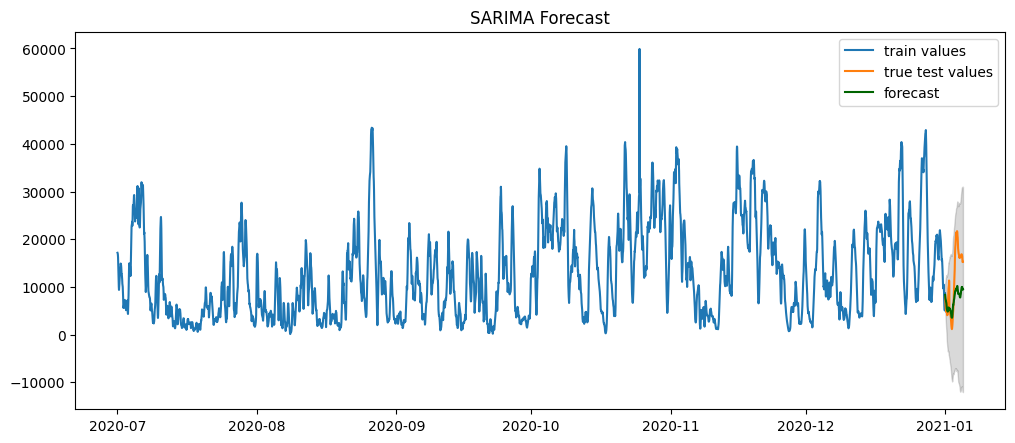

In [221]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

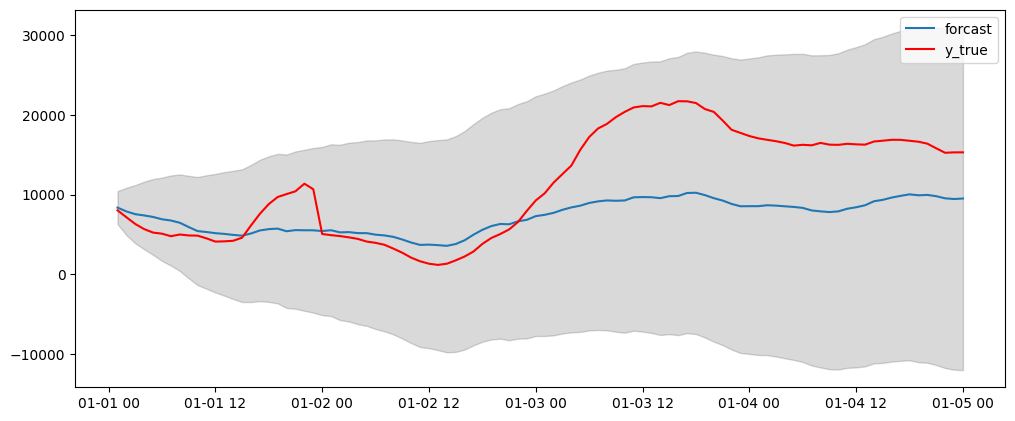

In [222]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 9

 **Model_9**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (2,1,0)(2,1,0)[24]**
 - time_varying_regression=False

In [385]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2021,1,1), end_date=dt.date(2021,6,16))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2021-5-31', test_init='2021-6-1', test_end='2021-6-4')

# train model
sarimax_9 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,2), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=True, 
                    mle_regression=False).fit()

MissingDataError: exog contains inf or nans

In [279]:
sarimax_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4417
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 24)   Log Likelihood              -36880.329
Date:                            Wed, 16 Jun 2021   AIC                          73784.659
Time:                                    23:48:56   BIC                          73861.364
Sample:                                07-01-2020   HQIC                         73811.714
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1                1.6842      0.038     43.844      0.000       1.609       1.760
ar.L2               -0.8933      0.033    -27.083      0.000      -0.958      -0.829
ma.L1               -0.0256      0.005     -5.075      0.000      -0.035      -0.016
ma.L2                0.0266      0.007      3.753      0.000       0.013       0.040
ar.S.L24             0.9667      0.007    137.138      0.000       0.953       0.980
ma.S.L24            -0.0223      0.006     -3.547      0.000      -0.035      -0.010
ma.S.L48            -0.0099      0.006     -1.780      0.075      -0.021       0.001
var.wind_speed       1.0649     14.229      0.075      0.940     -26.824      28.953
var.air_pressure  1.585e-05      0.019      0.001      0.999      -0.037       0.037
var.humidity         1.7277      2.298      0.752      0.452      -2.776       6.232
var.temperature      1.0636     14.055      0.076      0.940     -26.484      28.611
sigma2            1.111e+06      0.000   6.55e+09      0.000    1.11e+06    1.11e+06
===================================================================================
Ljung-Box (L1) (Q):                  66.42   Jarque-Bera (JB):          27452978.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                       389.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+25. Standard errors may be unstable.
"""

In [280]:
#get predicitons and confidence interval
sarimax_result = sarimax_9.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [281]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

40.32513236134815

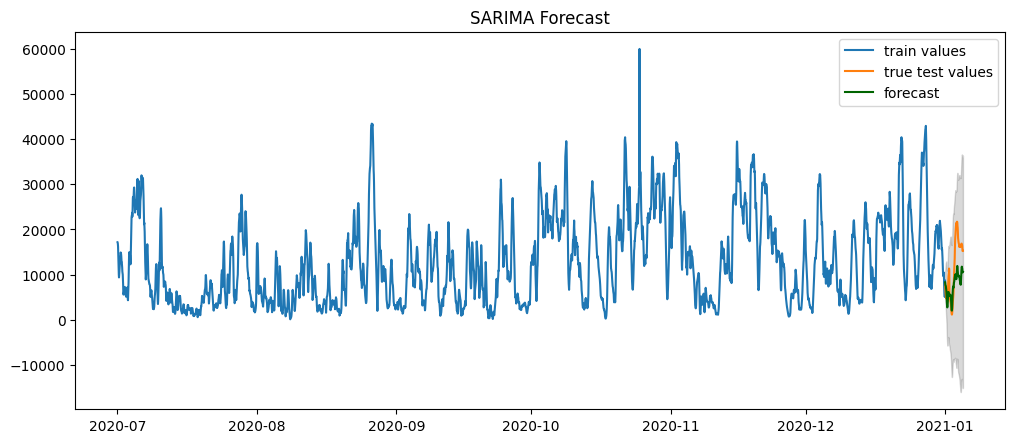

In [282]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

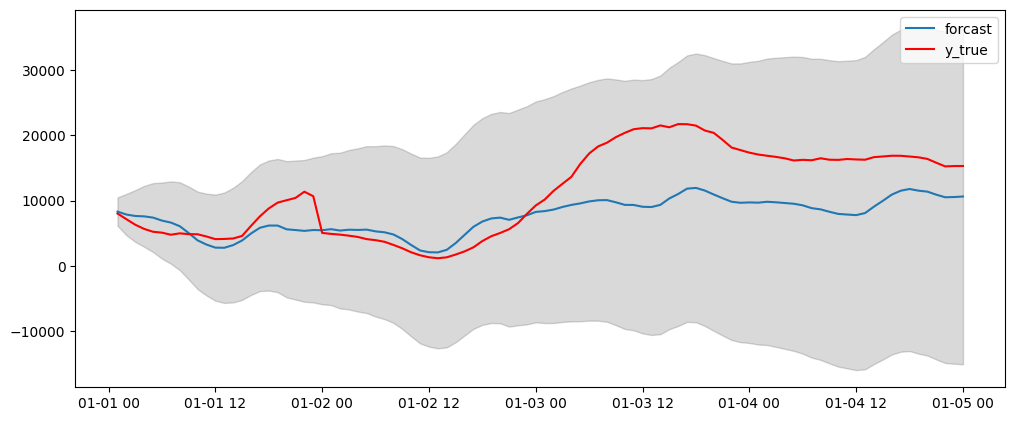

In [283]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 10

 **Model_10**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = features, target
 - model: **SARIMAX (2,0,1)(2,0,0)[12]**
 - time_varying_regression=False

In [334]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,7,1), end_date=dt.date(2021,1,30))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2020-12-31', 
                                                    test_init='2021-1-1', test_end='2021-1-4')


In [335]:
# train model
sarimax_10 = SARIMAX(y_train, 
                    exog=X_train, order=(2,0,1), 
                    seasonal_order=(2,0,0,12), 
                    time_varying_regression=False, 
                    mle_regression=True).fit()

KeyboardInterrupt: 

In [336]:
sarimax_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 4416
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood              -37157.253
Date:                             Thu, 17 Jun 2021   AIC                          74334.506
Time:                                     02:00:27   BIC                          74398.436
Sample:                                 07-01-2020   HQIC                         74357.054
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    7240.9206    141.938     51.015      0.000    6962.728    7519.113
air_pressure   -37.4381      3.643    -10.277      0.000     -44.578     -30.298
humidity       318.7382     28.285     11.269      0.000     263.301     374.176
temperature     67.7892     93.689      0.724      0.469    -115.837     251.416
ar.L1            1.5842      0.037     42.985      0.000       1.512       1.656
ar.L2           -0.6129      0.036    -16.850      0.000      -0.684      -0.542
ma.L1           -0.4255      0.036    -11.755      0.000      -0.496      -0.355
ar.S.L12        -0.0019      0.019     -0.100      0.920      -0.039       0.035
ar.S.L24         0.2305      0.003     71.108      0.000       0.224       0.237
sigma2        1.225e+06   4477.492    273.509      0.000    1.22e+06    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):          25564702.55
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -2.34
Prob(H) (two-sided):                  0.00   Kurtosis:                       375.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [337]:
#get predicitons and confidence interval
sarimax_result = sarimax_10.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [343]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

57.38487644841002

In [344]:
mae(y_test, central)

2759.992230450874

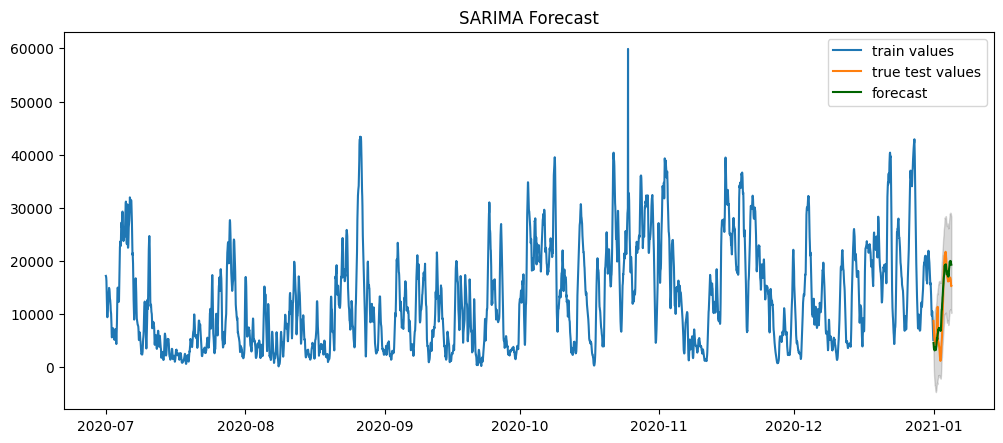

In [341]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

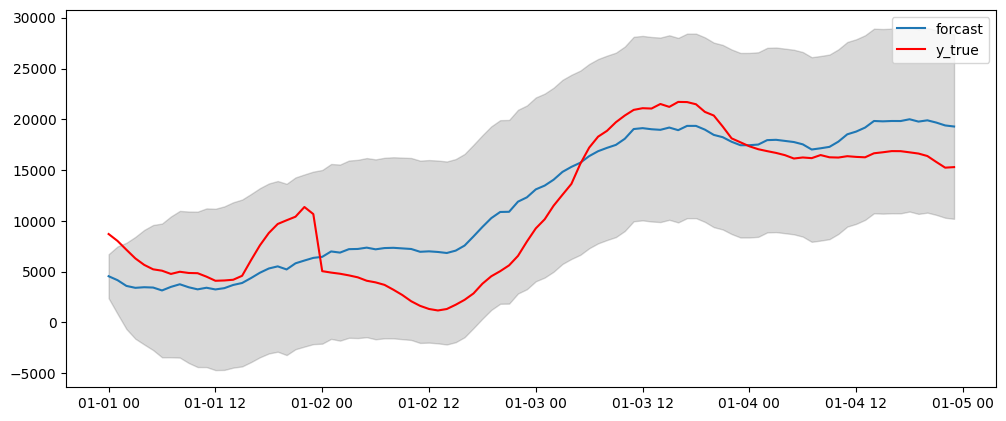

In [384]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## RandomForest

In [448]:
df = pd.DataFrame(target_df, columns=['production']).copy()
df["x_1"] = df["production"].shift(1)
df["x_2"] = df["production"].shift(2)
df["x_3"] = df["production"].shift(3)
df["x_4"] = df["production"].shift(4)
df["x_5"] = df["production"].shift(5)
df["x_6"] = df["production"].shift(6)
df["x_7"] = df["production"].shift(7)
df["x_8"] = df["production"].shift(8)
df["x_9"] = df["production"].shift(9)
df["x_10"] = df["production"].shift(10)
df["x_11"] = df["production"].shift(11)
df["x_12"] = df["production"].shift(12)

In [449]:
# Extract the trend using a well chosen moving average
df['ma_24'] = df['x_2'].rolling(window=24).mean()
df['ma_12'] = df['x_2'].rolling(window=12).mean()
df['ma_3'] = df['x_2'].rolling(window=3).mean()
df['ma_2'] = df['x_2'].rolling(window=2).mean()

df["ewma_2"] = df["x_2"].ewm(halflife=2).mean()
df["ewma_3"] = df["x_2"].ewm(halflife=3).mean()
df["ewma_12"] = df["x_2"].ewm(halflife=12).mean()
df["ewma_24"] = df["x_2"].ewm(halflife=24).mean()

In [450]:
# Drop nan
df = df.dropna()

#train test split
X, y = get_X_y(df.production, df.drop('production', axis=1), init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,3), scaled=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24)

In [451]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [65]:
# Keep track of test_indexes
test_indexes = np.arange(len(X_train), len(X))
test_indexes

array([2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243,
       2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254,
       2255, 2256])

In [66]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [462]:
def get_next_features(train_features, train_target):
    data = pd.DataFrame(np.append(train_target.reshape(-1,1),train_features, axis=1), columns=df.columns)
    t_feat = pd.Series(index=X.columns, dtype='float64')
    #print(data.index[-1])
    for _t in range(1,13):
        exec(f't_feat["x_{_t}"] = data.iloc[-{_t}]["production"]')
    for _t in [2, 3, 12, 24]:
        #print(data['x_2'].append(pd.Series(t_feat['x_1'])).rolling(window=_t).mean().iloc[-1])
        exec(f"t_feat['ma_{_t}'] = data['x_1'].append(pd.Series(t_feat['x_1'])).rolling(window={_t}).mean().iloc[-1]")
        exec(f"t_feat['ewma_{_t}'] = data['x_1'].append(pd.Series(t_feat['x_1'])).ewm(halflife={_t}).mean().iloc[-1]")
    return t_feat.values

def evaluate_performance_hourly_prediction(y_train, y_test, predictor, X):
    predictions = []
    train_target = y_train.values
    train_features = X.values
    i=0
    for _ in range(len(y_test)):
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_target)
        next_features = get_next_features(train_features, train_target)
        prediction = predictor.predict(next_features.reshape(1,-1))[0]
        #print(np.array([prediction]).shape)
        train_target = np.append(train_target, np.array([prediction]), axis=0)
        train_features = np.append(train_features, next_features.reshape(1,-1), axis=0)
        predictions.append(prediction)
        i+=1
    #print(i)
    mape = np.mean(np.abs(np.array(predictions) - np.array(y_test))/np.abs(np.array(y_test)))
    return y_test, predictions, mape

In [463]:
results = evaluate_performance_hourly_prediction(y_train=y_train, y_test=y_test,
                                                         predictor=random_forest, X=X_train)

In [452]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [464]:
# MAPE
results[2]

0.670809018654846

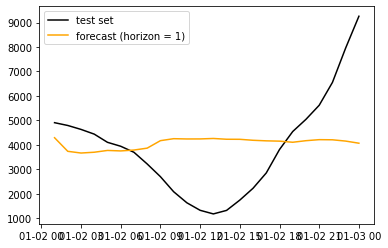

In [465]:
plt.plot(results[0], c='black', label='test set')
plt.plot(pd.Series(results[1], index=results[0].index), c='orange', label='forecast (horizon = 1)')
plt.legend()

In [466]:
importances = random_forest.feature_importances_
pd.DataFrame(zip(importances, list(X_train.columns))).sort_values(by=0, ascending=False)

,0,1
0,0.987438,x_1
1,0.002145,x_2
2,0.001143,x_3
15,0.001138,ma_2
3,0.001109,x_4
14,0.000872,ma_3
16,0.000679,ewma_2
12,0.000541,ma_24
11,0.000531,x_12
19,0.000528,ewma_24


# Evaluations

In [68]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## model_8

In [ ]:
y_pred = model_8.forecast(len(y_test), exog=X_test, alpha=0.05)

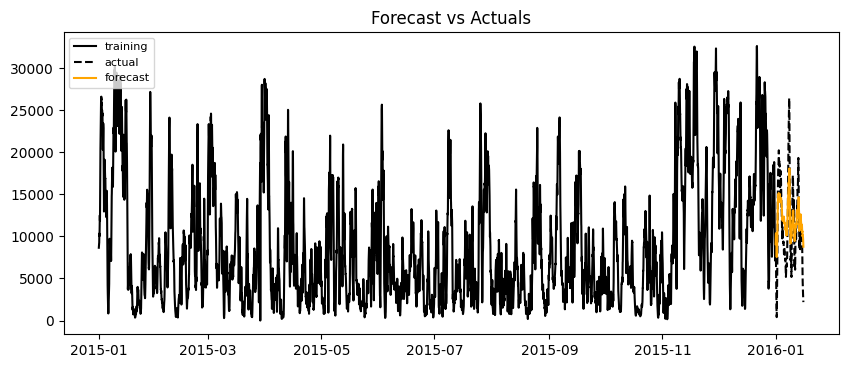

In [58]:
plot_forecast(y_pred, y_train, y_test)

In [45]:
model_8.mae

340.0432823356836

In [48]:
mae(y_test, y_pred)

3474.8045601605695

In [49]:
mse(y_test, y_pred)

17229826.977893803

In [50]:
mean_absolute_percentage_error(y_test, y_pred)

62.571837013493834

## model_10

In [71]:
y_pred = model_10.forecast(len(y_test), exog=X_test, alpha=0.05)

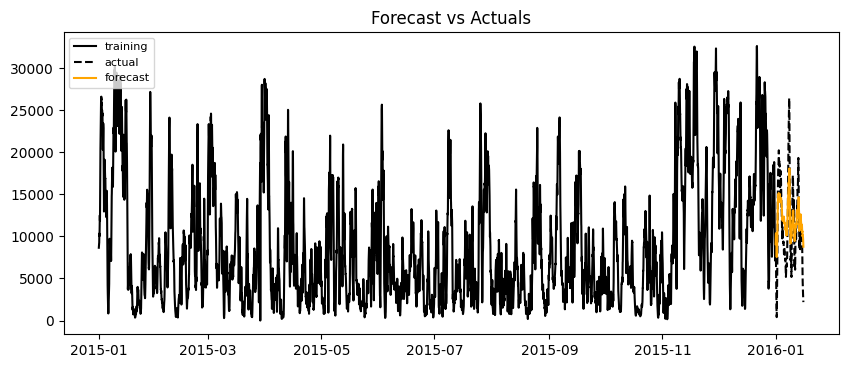

In [58]:
plot_forecast(y_pred, y_train, y_test)

In [72]:
mae(y_test, y_pred)

2827.8653712675423

In [73]:
mse(y_test, y_pred)

11652640.658651238

In [74]:
mean_absolute_percentage_error(y_test, y_pred)

50.545070786224656

## model_11

In [87]:
y_pred = model_11.forecast(len(y_test), exog=X_test, alpha=0.05)

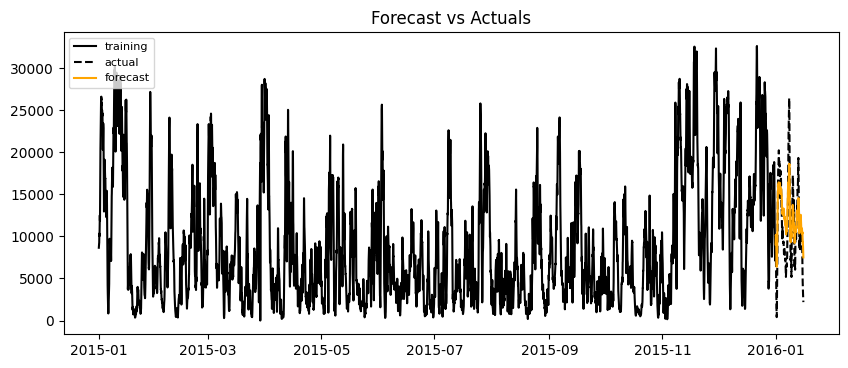

In [88]:
plot_forecast(y_pred, y_train, y_test)

In [89]:
mae(y_test, y_pred)

2741.0597859021373

In [90]:
mse(y_test, y_pred)

10602976.346378602

In [91]:
mean_absolute_percentage_error(y_test, y_pred)

47.22682448948714

## model_12

<AxesSubplot:xlabel='Date'>

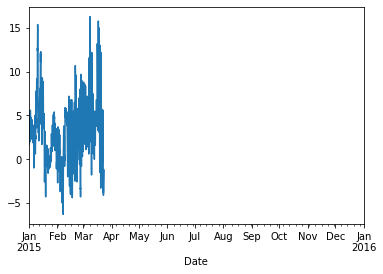

In [105]:
X_train['air_pressure'].plot()

In [104]:
X_train.isna().sum()

wind_speed         0
air_pressure    6808
dtype: int64

In [101]:
model_12 = SARIMAX(endog=y_train, exog=X_train, order=(1,1,2), seasonal_order=(2,0,0,24)).fit()

MissingDataError: exog contains inf or nans

In [57]:
y_pred = model_12.forecast(len(y_test), exog=X_test, alpha=0.05)

## baseline

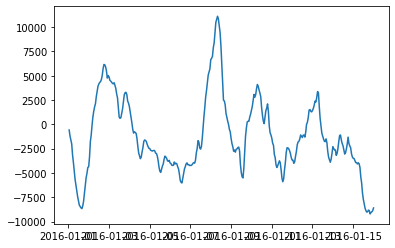

In [43]:
residuals = y_test - y_pred
plt.plot(residuals)

In [46]:
sarimax.mae

340.0432823356836

In [36]:
mae(y_test, forecast)

3474.8045601605695

In [37]:
sarimax.mse

370485.49749783427

In [38]:
mse(y_test, forecast)

17229826.977893803

In [39]:
mean_absolute_percentage_error(y_test, forecast)

62.571837013493834

In [34]:
# asbolute values MAPE
baseline = mean_absolute_percentage_error(y_test, forecast)
baseline

8.52754434601609

In [35]:
# log values MAPE
log_baseline = mean_absolute_percentage_error(np.log(y_test), np.log(forecast))
log_baseline

0.8707221647966732

In [67]:
# SMARD forcast MAPE
mean_absolute_percentage_error(y_test, forcasted_df.loc[dt.date(2016,1,1):dt.date(2016,3,31)])

NameError: name 'forcasted_df' is not defined

In [ ]:
# SMARD log forcast MAPE
THE_BAR = mean_absolute_percentage_error(y_test, np.log(mini_forecast))
THE_BAR

# scrap